# Portfolio Optimization Methods (Walk-Forward Backtesting)

Goal: compare portfolio allocation methods under realistic constraints, with  walk-forward backtesting (rolling train/test).


## 1. Setup


In [41]:
from pathlib import Path
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)


In [42]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)


## 2. Data
We download daily adjusted close prices from Yahoo Finance using `yfinance`.


In [43]:
TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]
START_DATE = "2018-01-01"
END_DATE = "2024-12-31"

TICKERS, START_DATE, END_DATE


(['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META'], '2018-01-01', '2024-12-31')

In [44]:
prices = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True,
    progress=False
)["Close"]

prices = prices.dropna()
prices.head()


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2018-01-02,40.341888,59.450500,53.258099,180.161514,79.050377
2018-01-03,40.334866,60.209999,54.166733,183.388977,79.418282
2018-01-04,40.522221,60.479500,54.377140,183.051331,80.117264
2018-01-05,40.983582,61.457001,55.098194,185.553864,81.110580
2018-01-08,40.831356,62.343498,55.292725,186.973923,81.193336


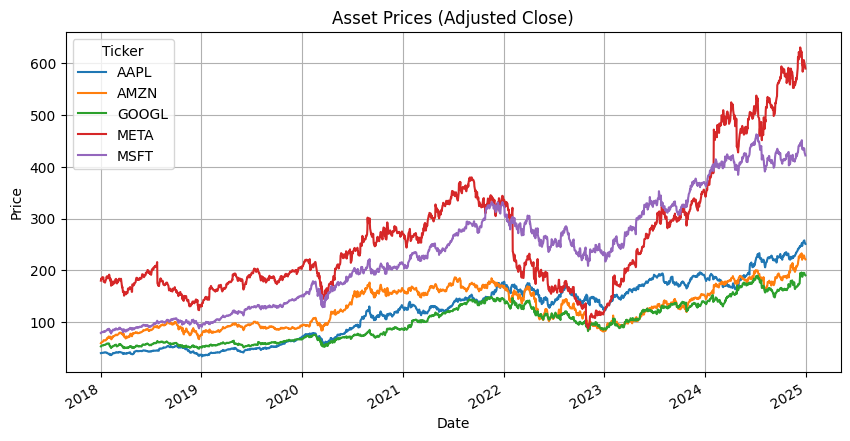

WindowsPath('../reports/figures/prices.png')

In [45]:
ax = prices.plot()
ax.set_title("Asset Prices (Adjusted Close)")
ax.set_ylabel("Price")
ax.grid(True)

plt.savefig(FIG_DIR / "prices.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "prices.png"


In [46]:
returns = prices.pct_change().dropna()
returns.head()


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2018-01-03,-0.000174,0.012775,0.017061,0.017914,0.004654
2018-01-04,0.004645,0.004476,0.003884,-0.001841,0.008801
2018-01-05,0.011385,0.016163,0.013260,0.013671,0.012398
2018-01-08,-0.003714,0.014425,0.003531,0.007653,0.001020
2018-01-09,-0.000115,0.004676,-0.001274,-0.002178,-0.000680


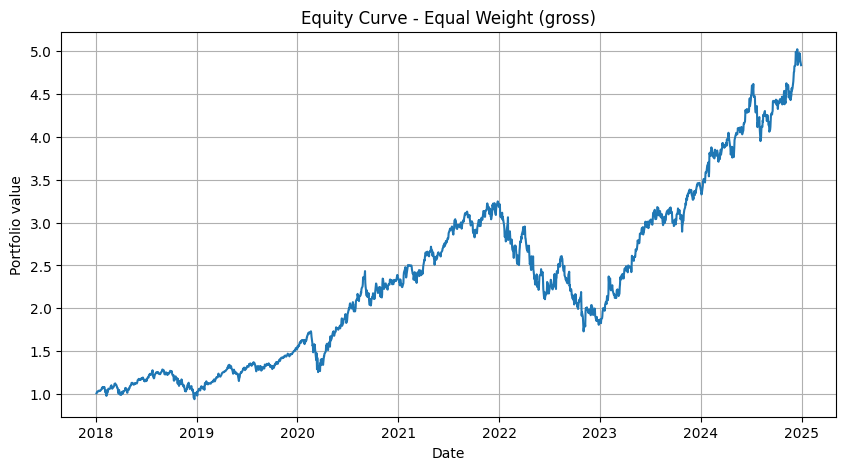

WindowsPath('../reports/figures/equity_curve.png')

In [47]:
w_eq = np.repeat(1/len(TICKERS), len(TICKERS))  # equal weights
port_ret_eq = returns @ w_eq

equity_eq = (1 + port_ret_eq).cumprod()

plt.plot(equity_eq)
plt.title("Equity Curve - Equal Weight (gross)")
plt.ylabel("Portfolio value")
plt.xlabel("Date")
plt.grid(True)

plt.savefig(FIG_DIR / "equity_curve.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "equity_curve.png"


### Performance Metrics (Baseline)

To evaluate portfolio performance, we compute the following metrics:

- **CAGR (Compound Annual Growth Rate)**: measures the annualized growth rate of the portfolio.
- **Volatility**: annualized standard deviation of portfolio returns, used as a risk proxy.
- **Sharpe Ratio**: risk-adjusted return, defined as the ratio of average excess return to volatility.
- **Maximum Drawdown**: worst peak-to-trough loss, capturing downside risk.

These metrics provide a first quantitative assessment of the baseline Equal-Weight portfolio,
before introducing optimization, constraints, and walk-forward rebalancing.
The Equal-Weight portfolio is used as a naive baseline, providing a simple benchmark against which
more sophisticated optimization methods will be compared.


In [48]:
def compute_metrics(portfolio_returns, equity_curve, freq=252):
    cagr = equity_curve.iloc[-1] ** (freq / len(equity_curve)) - 1
    vol = portfolio_returns.std() * np.sqrt(freq)
    sharpe = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(freq)

    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1
    max_dd = drawdown.min()

    return pd.Series({
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd
    })


metrics_eq = compute_metrics(port_ret_eq, equity_eq)
metrics_eq


CAGR            0.253270
Volatility      0.281062
Sharpe          0.944375
Max Drawdown   -0.466735
dtype: float64

At this stage, performance is evaluated using a static Equal-Weight allocation.
In the following section, we introduce portfolio optimization methods to improve
risk-adjusted returns under realistic constraints.


## 3. Portfolio Allocation Methods

We now introduce portfolio optimization techniques that aim to improve
risk-adjusted performance compared to the Equal-Weight benchmark.

In this section, portfolio weights are determined by solving optimization
problems based on historical return statistics, under realistic constraints.
The first method considered is the **Minimum Variance portfolio**.


### 3.1 Minimum Variance Portfolio

The Minimum Variance portfolio aims to construct asset weights that minimize
the overall portfolio variance, independently of expected returns.

Formally, the objective is to solve:

$$
\min_{w} \; w^\top \Sigma w
$$

subject to the following constraints:
- the portfolio is **long-only**: $w_i \ge 0$,
- portfolio weights sum to one: $\sum_i w_i = 1$,
- individual asset weights are capped to avoid excessive concentration.

This approach focuses purely on risk reduction and diversification.
It provides a natural first step beyond the Equal-Weight benchmark,
and serves as a reference for more return-oriented optimization methods.



In [49]:
from scipy.optimize import minimize

def min_variance_weights(returns, max_weight=0.4):
    """
    Compute Minimum Variance portfolio weights under long-only
    and weight cap constraints.
    """
    cov = returns.cov().values
    n = cov.shape[0]

    def portfolio_variance(w):
        return w.T @ cov @ w

    
    constraints = ({
        "type": "eq",
        "fun": lambda w: np.sum(w) - 1
    })

    
    bounds = tuple((0.0, max_weight) for _ in range(n))

    
    w0 = np.repeat(1 / n, n)

    res = minimize(
        portfolio_variance,
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )

    return pd.Series(res.x, index=returns.columns)


weights_minvar = min_variance_weights(returns)
weights_minvar


Ticker
AAPL     0.2
AMZN     0.2
GOOGL    0.2
META     0.2
MSFT     0.2
dtype: float64

**Interpretation.**

In this asset universe, the Minimum Variance optimization yields weights
that are very close to an Equal-Weight allocation.

This outcome is expected when assets exhibit similar volatility levels
and are strongly correlated, especially under long-only and weight cap
constraints. In such cases, the Equal-Weight portfolio already provides
a well-diversified, low-variance allocation.

This result highlights that portfolio optimization outcomes depend
critically on the covariance structure of returns and imposed constraints,
and that optimization does not necessarily lead to highly concentrated
allocations.


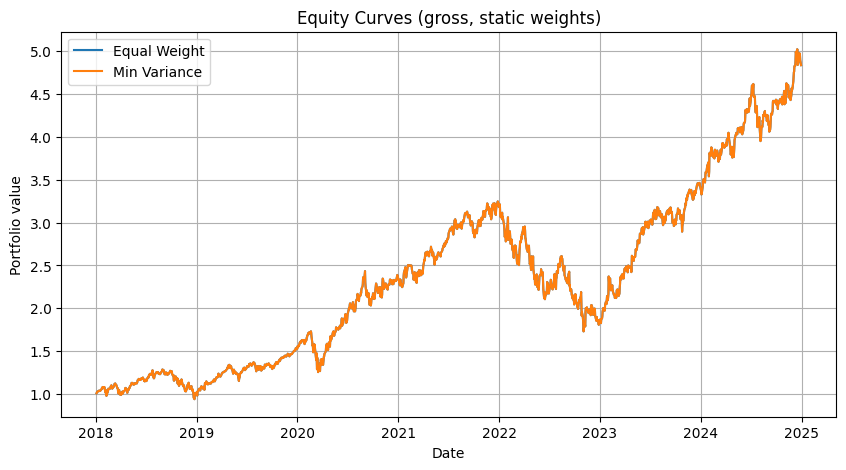

WindowsPath('../reports/figures/equity_curve_comparison.png')

In [50]:
# Portfolio returns using Minimum Variance weights (static)
port_ret_minvar = returns @ weights_minvar

# Equity curves
equity_minvar = (1 + port_ret_minvar).cumprod()

plt.figure()
plt.plot(equity_eq, label="Equal Weight")
plt.plot(equity_minvar, label="Min Variance")
plt.title("Equity Curves (gross, static weights)")
plt.ylabel("Portfolio value")
plt.xlabel("Date")
plt.grid(True)
plt.legend()

plt.savefig(FIG_DIR / "equity_curve_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "equity_curve_comparison.png"


### 3.2 Maximum Sharpe Ratio Portfolio

The Maximum Sharpe portfolio seeks to maximize the portfolio's risk-adjusted
return by explicitly balancing expected returns against risk.

Formally, the optimisation problem can be written as:

$$
\max_{w}\; \frac{w^\top \mu}{\sqrt{w^\top \Sigma w}}
$$

where:
- $\mu$ denotes the vector of expected asset returns,
- $\Sigma$ is the covariance matrix of asset returns,
- $w$ is the vector of portfolio weights.

In practice, this objective corresponds to maximising the portfolio's Sharpe
ratio (assuming a zero risk-free rate). Unlike the Minimum Variance portfolio,
this method is return-driven and therefore more sensitive to estimation error
in expected returns.

The same realistic constraints are enforced:
- long-only weights: $w_i \ge 0$,
- full investment: $\sum_i w_i = 1$,
- individual weight caps to limit concentration.


In [51]:
def max_sharpe_weights(returns, max_weight=0.4, rf=0.0, freq=252, ridge=1e-6):

    mu = returns.mean().values * freq                 # annualized expected returns
    cov = returns.cov().values * freq                 # annualized covariance
    cov = cov + ridge * np.eye(cov.shape[0])          # numerical stability
    n = len(mu)

    def neg_sharpe(w):
        port_ret = w @ mu - rf
        port_vol = np.sqrt(w.T @ cov @ w)
        if port_vol <= 1e-12:
            return 1e6
        return -(port_ret / port_vol)

    
    constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1},)

    
    bounds = tuple((0.0, max_weight) for _ in range(n))

    
    w0 = np.repeat(1 / n, n)

    res = minimize(
        neg_sharpe,
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )

    return pd.Series(res.x, index=returns.columns)


weights_maxsharpe = max_sharpe_weights(returns, max_weight=0.4, rf=0.0)
weights_maxsharpe


Ticker
AAPL     0.400000
AMZN     0.096326
GOOGL    0.095355
META     0.008319
MSFT     0.400000
dtype: float64

**Interpretation**

The Maximum Sharpe optimization leads to a more concentrated allocation compared
to both the Equal-Weight and Minimum Variance portfolios.

In this universe, the optimizer assigns the maximum allowed weight to the assets
with the highest estimated risk-adjusted returns (here AAPL and MSFT), while
allocating smaller weights to the remaining assets.

This behavior is expected:
- the Sharpe ratio explicitly trades off expected returns against risk,
- assets with higher historical returns tend to dominate the allocation,
- weight caps prevent excessive concentration and keep the solution realistic.

This result illustrates a key property of return-driven optimization methods:
they are highly sensitive to expected return estimates and constraints, and may
produce significantly different portfolios than risk-only approaches.


In [52]:
port_ret_maxsharpe = (returns * weights_maxsharpe).sum(axis=1)

equity_maxsharpe = (1 + port_ret_maxsharpe).cumprod()

equity_maxsharpe.head()


Date
2018-01-03    1.004798
2018-01-04    1.010993
2018-01-05    1.023578
2018-01-08    1.024307
2018-01-09    1.024300
dtype: float64

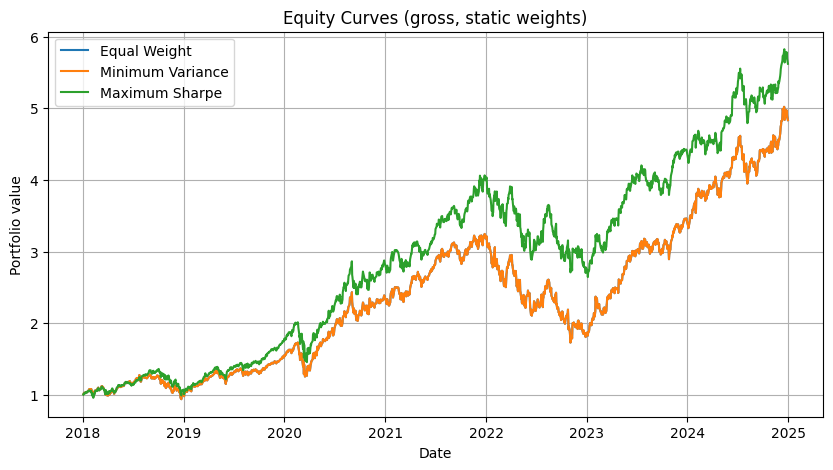

WindowsPath('../reports/figures/equity_curve_comparison.png')

In [53]:
plt.plot(equity_eq, label="Equal Weight")
plt.plot(equity_minvar, label="Minimum Variance")
plt.plot(equity_maxsharpe, label="Maximum Sharpe")

plt.title("Equity Curves (gross, static weights)")
plt.ylabel("Portfolio value")
plt.xlabel("Date")
plt.grid(True)
plt.legend()

plt.savefig(FIG_DIR / "equity_curve_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "equity_curve_comparison.png"


In [54]:
metrics_eq = compute_metrics(port_ret_eq, equity_eq)
metrics_minvar = compute_metrics(port_ret_minvar, equity_minvar)
metrics_maxsharpe = compute_metrics(port_ret_maxsharpe, equity_maxsharpe)

metrics = pd.DataFrame({
    "Equal Weight": metrics_eq,
    "Minimum Variance": metrics_minvar,
    "Maximum Sharpe": metrics_maxsharpe
})

metrics


,Equal Weight,Minimum Variance,Maximum Sharpe
CAGR,0.253270,0.253270,0.280619
Volatility,0.281062,0.281062,0.270607
Sharpe,0.944375,0.944375,1.049946
Max Drawdown,-0.466735,-0.466735,-0.349138


**Quantitative comparison**

The table above highlights clear differences between the three allocation
strategies.

The Maximum Sharpe portfolio achieves the highest compound annual growth rate
and the best Sharpe ratio, while also exhibiting a significantly smaller maximum
drawdown than the Equal-Weight and Minimum Variance portfolios.

In contrast, the Equal-Weight and Minimum Variance strategies deliver nearly
identical performance in this asset universe, suggesting that under strong
correlations and binding constraints, risk-only optimization provides limited
benefits over naive diversification.

While these results appear favorable for the Maximum Sharpe portfolio, it is
important to note that all optimizations are performed using full-sample
historical estimates. This raises concerns about estimation error and
overfitting, motivating the introduction of walk-forward rebalancing in the
next section.


## 4. Walk-Forward Backtesting Framework

So far, portfolio weights have been computed using the full sample of historical
data, resulting in in-sample (static) performance.

In practice, portfolio allocation decisions must be made using only information
available at the time of rebalancing. To account for this, we adopt a
**walk-forward backtesting framework**, in which portfolio weights are
periodically re-estimated on a rolling window and applied out-of-sample.

This approach allows us to:
- mitigate look-ahead bias,
- assess the robustness of optimization methods,
- quantify the impact of estimation error,
- incorporate rebalancing frequency and transaction costs.


### Walk-Forward Setup

The walk-forward backtest is implemented using a rolling train–test procedure:

- **Training window**: a fixed-length historical window used to estimate
  expected returns and covariance matrices.
- **Test window**: a forward-looking period during which portfolio weights
  are held constant and applied out-of-sample.
- **Rebalancing**: portfolio weights are re-estimated at the end of each test
  window and rolled forward.

In this project, we use:
- a training window of **252 trading days** (approximately one year),
- a test window of **21 trading days** (approximately one month),
- monthly rebalancing.

This setup reflects a realistic investment process, balancing estimation
stability with responsiveness to changing market conditions.


In [55]:
TRAIN_WINDOW = 252   # 1 year
TEST_WINDOW = 21     # 1 month
REB_FREQ = TEST_WINDOW

TRAIN_WINDOW, TEST_WINDOW


(252, 21)

In [56]:
n_days = len(returns)
start_idx = TRAIN_WINDOW
end_idx = n_days - TEST_WINDOW

walkforward_starts = list(range(start_idx, end_idx + 1, TEST_WINDOW))

len(walkforward_starts), walkforward_starts[:3], walkforward_starts[-3:]


(71, [252, 273, 294], [1680, 1701, 1722])

In [57]:
wf_returns_eq = []
wf_returns_minvar = []
wf_returns_maxsharpe = []

wf_weights_minvar = []
wf_weights_maxsharpe = []


In [58]:
for t0 in walkforward_starts:

    train = returns.iloc[t0 - TRAIN_WINDOW : t0]
    test  = returns.iloc[t0 : t0 + TEST_WINDOW]

    w_eq = np.repeat(1 / train.shape[1], train.shape[1])
    wf_returns_eq.append(test @ w_eq)

    w_minvar = min_variance_weights(train, max_weight=0.4)
    wf_weights_minvar.append(w_minvar)
    wf_returns_minvar.append(test @ w_minvar.values)

    w_maxsh = max_sharpe_weights(train, max_weight=0.4, rf=0.0)
    wf_weights_maxsharpe.append(w_maxsh)
    wf_returns_maxsharpe.append(test @ w_maxsh.values)

wf_returns_eq = pd.concat(wf_returns_eq).sort_index()
wf_returns_minvar = pd.concat(wf_returns_minvar).sort_index()
wf_returns_maxsharpe = pd.concat(wf_returns_maxsharpe).sort_index()

wf_returns_eq.head(), wf_returns_eq.index.min(), wf_returns_eq.index.max()


(Date
 2019-01-04    0.047539
 2019-01-07    0.006427
 2019-01-08    0.016832
 2019-01-09    0.008299
 2019-01-10   -0.001595
 dtype: float64,
 Timestamp('2019-01-04 00:00:00'),
 Timestamp('2024-12-05 00:00:00'))

In [59]:
wf_equity_eq = (1 + wf_returns_eq).cumprod()
wf_equity_minvar = (1 + wf_returns_minvar).cumprod()
wf_equity_maxsharpe = (1 + wf_returns_maxsharpe).cumprod()

wf_equity_eq.head()


Date
2019-01-04    1.047539
2019-01-07    1.054271
2019-01-08    1.072017
2019-01-09    1.080914
2019-01-10    1.079190
dtype: float64

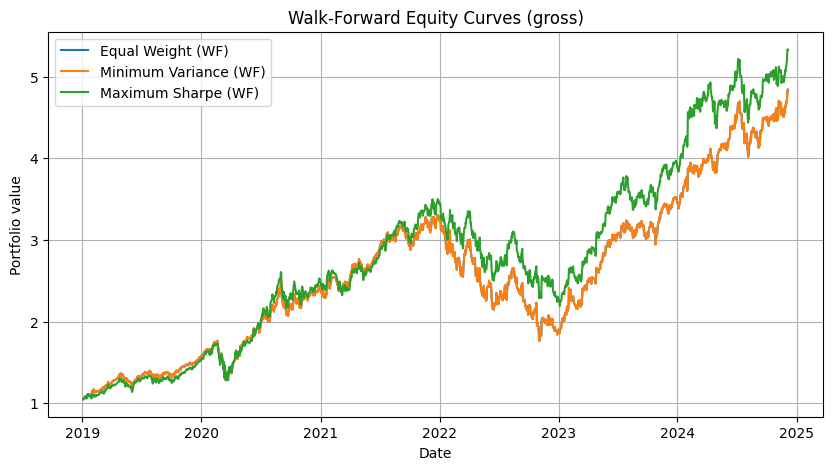

WindowsPath('../reports/figures/equity_curve_walkforward.png')

In [60]:
plt.plot(wf_equity_eq, label="Equal Weight (WF)")
plt.plot(wf_equity_minvar, label="Minimum Variance (WF)")
plt.plot(wf_equity_maxsharpe, label="Maximum Sharpe (WF)")

plt.title("Walk-Forward Equity Curves (gross)")
plt.ylabel("Portfolio value")
plt.xlabel("Date")
plt.grid(True)
plt.legend()

plt.savefig(FIG_DIR / "equity_curve_walkforward.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "equity_curve_walkforward.png"


In [61]:
# Walk-forward performance metrics
wf_metrics_eq = compute_metrics(wf_returns_eq, wf_equity_eq)
wf_metrics_minvar = compute_metrics(wf_returns_minvar, wf_equity_minvar)
wf_metrics_maxsharpe = compute_metrics(wf_returns_maxsharpe, wf_equity_maxsharpe)

wf_metrics = pd.DataFrame({
    "Equal Weight (WF)": wf_metrics_eq,
    "Minimum Variance (WF)": wf_metrics_minvar,
    "Maximum Sharpe (WF)": wf_metrics_maxsharpe
})

wf_metrics


,Equal Weight (WF),Minimum Variance (WF),Maximum Sharpe (WF)
CAGR,0.305526,0.305526,0.326660
Volatility,0.283013,0.283013,0.282314
Sharpe,1.084261,1.084261,1.142821
Max Drawdown,-0.466735,-0.466735,-0.375050


**Walk-forward performance analysis**

The walk-forward results provide a more realistic assessment of portfolio
optimization performance, as all allocations are computed using past data and
applied strictly out-of-sample.

Compared to the static full-sample results, performance differences across
strategies are significantly reduced. The Maximum Sharpe portfolio still
achieves the highest Sharpe ratio and the lowest maximum drawdown, but the
magnitude of its outperformance is more modest.

The Equal-Weight and Minimum Variance portfolios once again deliver nearly
identical results, highlighting the limited incremental benefit of risk-only
optimization in this asset universe under strong correlations and constraints.

Overall, these results illustrate a key insight: while optimization can improve
risk-adjusted performance, its benefits tend to shrink once estimation error,
rebalancing, and out-of-sample evaluation are properly accounted for.


## 5. Risk Decomposition & Benchmark Analysis

While walk-forward backtesting provides a realistic assessment of
out-of-sample performance, it does not explain **where performance comes from**
or **which risks are taken**.

In this section, we extend the analysis by comparing portfolio returns
to a market benchmark and by introducing additional risk-adjusted
and downside-risk metrics.

All metrics are computed using **walk-forward returns**, ensuring that
the analysis remains strictly out-of-sample.


### 5.1 Market Benchmark

To assess whether portfolio strategies generate **true risk-adjusted value**,
their performance must be evaluated relative to a broad market benchmark.

We use the **S&P 500 index** as a proxy for the overall equity market.
Comparing portfolio returns to the benchmark allows us to:

- distinguish market-driven performance from strategy-specific skill,
- quantify systematic risk exposure,
- compute CAPM-based metrics such as **Alpha** and **Beta**.

Benchmark returns are aligned strictly with the walk-forward evaluation period
to ensure a fully out-of-sample comparison.


In [62]:
# Market benchmark: S&P 500
bench = yf.download(
    "^GSPC",
    start=wf_returns_eq.index.min(),
    end=wf_returns_eq.index.max(),
    progress=False
)

price_col = "Adj Close" if "Adj Close" in bench.columns else "Close"
benchmark_prices = bench[price_col].dropna()

benchmark_returns = benchmark_prices.pct_change().dropna()

benchmark_returns = benchmark_returns.loc[
    wf_returns_eq.index.min(): wf_returns_eq.index.max()
]

price_col, benchmark_returns.head(), benchmark_returns.index.min(), benchmark_returns.index.max()


('Close',
 Ticker         ^GSPC
 Date                
 2019-01-07  0.007010
 2019-01-08  0.009695
 2019-01-09  0.004098
 2019-01-10  0.004518
 2019-01-11 -0.000146,
 Timestamp('2019-01-07 00:00:00'),
 Timestamp('2024-12-04 00:00:00'))

### 5.2 CAPM-Based Risk Decomposition: Alpha & Beta

To understand **where performance comes from**, raw or risk-adjusted returns
are not sufficient. We decompose strategy performance relative to the market
using **CAPM-based metrics**.

The relationship between strategy returns and market returns is modeled as:

$$
R_p = \alpha + \beta R_m + \varepsilon
$$

where:
- $R_p$ is the strategy return,
- $R_m$ is the market (benchmark) return,
- $\beta$ measures **systematic market exposure**,
- $\alpha$ measures **risk-adjusted excess performance** unexplained by the market.

---

#### **Beta**

Beta is defined as:

$$
\beta = \frac{\mathrm{Cov}(R_p, R_m)}{\mathrm{Var}(R_m)}
$$

Interpretation:
- $\beta > 1$: strategy amplifies market movements,
- $\beta < 1$: defensive exposure,
- $\beta \approx 1$: market-like behavior.

---

#### **Alpha**

Alpha is computed as the average excess return after removing market exposure:

$$
\alpha = \mathbb{E}[R_p - \beta R_m]
$$

Alpha is then **annualized** to express performance in yearly terms.

All Alpha and Beta estimates are computed using **walk-forward (out-of-sample) returns only**.


In [63]:
def capm_alpha_beta(strategy_returns: pd.Series, benchmark_returns: pd.Series, freq: int = 252):
    
    df = pd.concat([strategy_returns, benchmark_returns], axis=1, join="inner").dropna()
    df.columns = ["strategy", "benchmark"]

    # Beta = Cov(Rp, Rm) / Var(Rm)
    beta = df["strategy"].cov(df["benchmark"]) / df["benchmark"].var()

    # Alpha (daily) = mean(Rp - beta * Rm), then annualize
    alpha_daily = (df["strategy"] - beta * df["benchmark"]).mean()
    alpha_annual = alpha_daily * freq

    return pd.Series({"Beta": beta, "Alpha (annualized)": alpha_annual})

capm = pd.DataFrame({
    "Equal Weight (WF)": capm_alpha_beta(wf_returns_eq, benchmark_returns),
    "Minimum Variance (WF)": capm_alpha_beta(wf_returns_minvar, benchmark_returns),
    "Maximum Sharpe (WF)": capm_alpha_beta(wf_returns_maxsharpe, benchmark_returns),
})

capm


,Equal Weight (WF),Minimum Variance (WF),Maximum Sharpe (WF)
Beta,1.182992,1.182992,1.179903
Alpha (annualized),0.099330,0.099330,0.115973


### 5.3 Downside Risk Metrics: Sortino & Calmar Ratios

Traditional risk-adjusted metrics such as volatility and Sharpe ratio
penalize **upside and downside fluctuations equally**.
However, investors are typically more concerned with **downside risk**.

To better capture asymmetric risk, we introduce **downside-focused metrics**.

---

#### Downside Volatility

Downside volatility considers **only negative returns**:

$$
\sigma_- = \sqrt{ \mathbb{E} \left[ \min(R_t, 0)^2 \right] }
$$

It isolates harmful variability and ignores positive fluctuations.

---

#### Sortino Ratio

The **Sortino ratio** replaces total volatility with downside volatility:

$$
\text{Sortino} = \frac{\mathbb{E}[R_p]}{\sigma_-}
$$

Compared to the Sharpe ratio, it:
- penalizes only downside risk,
- better reflects investor risk perception,
- is more informative for skewed return distributions.

---

#### Calmar Ratio

The **Calmar ratio** measures return relative to maximum drawdown:

$$
\text{Calmar} = \frac{\text{CAGR}}{|\text{Max Drawdown}|}
$$

It captures the trade-off between:
- long-term growth,
- worst historical loss.

This metric is particularly relevant for strategies exposed to large drawdowns.

---

All metrics are computed using **walk-forward returns**, ensuring a strictly
out-of-sample evaluation.


In [64]:
def downside_volatility(returns, freq=252):
    downside = returns[returns < 0]
    return downside.std() * np.sqrt(freq)

def sortino_ratio(returns, freq=252):
    return returns.mean() * freq / downside_volatility(returns, freq)

def calmar_ratio(returns, equity_curve):
    cagr = equity_curve.iloc[-1] ** (252 / len(equity_curve)) - 1
    max_dd = (equity_curve / equity_curve.cummax() - 1).min()
    return cagr / abs(max_dd)

advanced_metrics = pd.DataFrame({
    "Equal Weight (WF)": {
        "Sortino": sortino_ratio(wf_returns_eq),
        "Calmar": calmar_ratio(wf_returns_eq, wf_equity_eq),
    },
    "Minimum Variance (WF)": {
        "Sortino": sortino_ratio(wf_returns_minvar),
        "Calmar": calmar_ratio(wf_returns_minvar, wf_equity_minvar),
    },
    "Maximum Sharpe (WF)": {
        "Sortino": sortino_ratio(wf_returns_maxsharpe),
        "Calmar": calmar_ratio(wf_returns_maxsharpe, wf_equity_maxsharpe),
    },
})

advanced_metrics


,Equal Weight (WF),Minimum Variance (WF),Maximum Sharpe (WF)
Sortino,1.441115,1.441115,1.600276
Calmar,0.654601,0.654601,0.870978


### 5.4 Interpretation of Risk Decomposition Results

The CAPM and downside-risk metrics provide deeper insight into the **sources of performance**.

Key observations:

- The **Maximum Sharpe (WF)** portfolio:
  - exhibits the highest **Alpha**, indicating genuine risk-adjusted outperformance,
  - shows a slightly lower **Beta**, reflecting improved efficiency relative to market risk,
  - achieves superior **Sortino** and **Calmar ratios**, indicating better downside protection.

- The **Equal-Weight** and **Minimum Variance** portfolios:
  - display nearly identical market exposure,
  - generate limited alpha,
  - offer similar downside-risk characteristics.

Overall, these results confirm that:
- optimization can improve risk-adjusted performance,
- gains remain moderate once evaluated **out-of-sample**,
- a large fraction of returns remains driven by market exposure.


## 6. Robustness & Realism Analysis

The previous sections evaluated performance and risk using walk-forward returns
and benchmark-based metrics. We now extend the analysis with additional measures
commonly used in professional risk management.

In particular, we introduce:
- the **Treynor ratio**, which scales excess return by **systematic market risk** (beta),
- **historical Value at Risk (VaR)**, which summarizes downside tail risk using return quantiles.

These metrics help assess whether outperformance remains attractive once market
exposure and tail risk are explicitly considered.


### 6.1 Treynor Ratio

The **Treynor ratio** measures risk-adjusted performance by scaling excess
returns by **systematic market risk** rather than total volatility.

It is defined as:

$$
\text{Treynor} = \frac{\mathbb{E}[R_p - R_f]}{\beta}
$$

where:
- $R_p$ is the portfolio return,
- $R_f$ is the risk-free rate (set to zero in this analysis),
- $\beta$ is the CAPM beta relative to the market benchmark.

Unlike the Sharpe ratio, which penalizes **total risk**, the Treynor ratio
focuses exclusively on **market risk**. It is therefore most appropriate when
comparing portfolios that are already well-diversified.

All Treynor ratios are computed using **walk-forward (out-of-sample) returns**
and the corresponding CAPM betas estimated in the previous section.


In [65]:
def treynor_ratio(returns: pd.Series, beta: float, rf: float = 0.0, freq: int = 252):
    
    excess_return_annual = (returns.mean() - rf) * freq
    return excess_return_annual / beta


treynor = pd.Series({
    "Equal Weight (WF)": treynor_ratio(
        wf_returns_eq, capm.loc["Beta", "Equal Weight (WF)"]
    ),
    "Minimum Variance (WF)": treynor_ratio(
        wf_returns_minvar, capm.loc["Beta", "Minimum Variance (WF)"]
    ),
    "Maximum Sharpe (WF)": treynor_ratio(
        wf_returns_maxsharpe, capm.loc["Beta", "Maximum Sharpe (WF)"]
    ),
}, name="Treynor Ratio")

treynor



Equal Weight (WF)        0.259393
Minimum Variance (WF)    0.259393
Maximum Sharpe (WF)      0.273442
Name: Treynor Ratio, dtype: float64

### 6.2 Historical Value at Risk (VaR)

Beyond average performance metrics, it is important to quantify **tail risk**:
how bad returns can get during extreme days.

We compute the **historical Value at Risk (VaR)** at confidence level $q$ as the
empirical quantile of the return distribution:

$$
\mathrm{VaR}_{q}(R) = \text{Quantile}_{(1-q)}(R)
$$

For example, a 95% VaR corresponds to:

$$
\mathrm{VaR}_{0.95}(R) = \text{Quantile}_{0.05}(R)
$$

Interpretation:
- $\mathrm{VaR}_{0.95} = -2\%$ means that **on 95% of days, returns were better than -2%**,
  and only 5% of days were worse.

All VaR numbers are computed using **walk-forward (out-of-sample) daily returns**
to remain consistent with the rest of the evaluation framework.


In [66]:
def historical_var(returns: pd.Series, q: float = 0.95):
    
    return returns.quantile(1 - q)


var = pd.DataFrame({
    "Equal Weight (WF)": {
        "VaR 95%": historical_var(wf_returns_eq, q=0.95),
        "VaR 99%": historical_var(wf_returns_eq, q=0.99),
    },
    "Minimum Variance (WF)": {
        "VaR 95%": historical_var(wf_returns_minvar, q=0.95),
        "VaR 99%": historical_var(wf_returns_minvar, q=0.99),
    },
    "Maximum Sharpe (WF)": {
        "VaR 95%": historical_var(wf_returns_maxsharpe, q=0.95),
        "VaR 99%": historical_var(wf_returns_maxsharpe, q=0.99),
    },
})

var


,Equal Weight (WF),Minimum Variance (WF),Maximum Sharpe (WF)
VaR 95%,-0.028719,-0.028719,-0.027041
VaR 99%,-0.046313,-0.046313,-0.044167


## 7. Sensitivity to Asset Universe

So far, the analysis focused on a highly correlated equity universe.
To assess the robustness of the conclusions, we repeat the same methodology
on a more heterogeneous **multi-asset universe**.

This experiment illustrates how portfolio optimization outcomes
depend strongly on asset correlations, volatility heterogeneity,
and diversification opportunities.


In [67]:
# Alternative multi-asset universe
tickers_alt = ["SPY", "EFA", "EEM", "AGG", "GLD"]

prices_alt = yf.download(
    tickers_alt,
    start="2015-01-01",
    progress=False
)

price_col = "Adj Close" if "Adj Close" in prices_alt.columns else "Close"
prices_alt = prices_alt[price_col].dropna()

returns_alt = prices_alt.pct_change().dropna()

price_col, returns_alt.head()


('Close',
 Ticker           AGG       EEM       EFA       GLD       SPY
 Date                                                        
 2015-01-05  0.002173 -0.017797 -0.023605  0.015077 -0.018059
 2015-01-06  0.002530 -0.004202 -0.011327  0.011399 -0.009419
 2015-01-07 -0.000180  0.021625  0.011115 -0.005891  0.012461
 2015-01-08 -0.001533  0.017036  0.013529 -0.004209  0.017745
 2015-01-09  0.002437 -0.003299 -0.004839  0.011385 -0.008014)

In [68]:
# Equal-Weight baseline on the alternative universe (static weights, gross)
n_alt = returns_alt.shape[1]
w_eq_alt = np.repeat(1 / n_alt, n_alt)

port_ret_eq_alt = (returns_alt * w_eq_alt).sum(axis=1)
equity_eq_alt = (1 + port_ret_eq_alt).cumprod()

w_eq_alt, equity_eq_alt.head()


(array([0.2, 0.2, 0.2, 0.2, 0.2]),
 Date
 2015-01-05    0.991558
 2015-01-06    0.989373
 2015-01-07    0.997115
 2015-01-08    1.005605
 2015-01-09    1.005136
 dtype: float64)

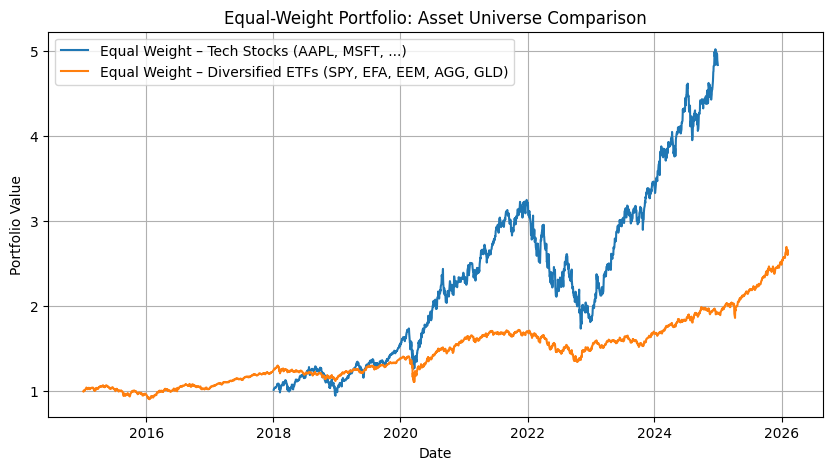

WindowsPath('../reports/figures/equity_curve_universe_comparison.png')

In [69]:
# Comparison of Equal-Weight portfolios across universes
plt.figure(figsize=(10, 5))

plt.plot(equity_eq, label="Equal Weight – Tech Stocks (AAPL, MSFT, ...)")
plt.plot(equity_eq_alt, label="Equal Weight – Diversified ETFs (SPY, EFA, EEM, AGG, GLD)")

plt.title("Equal-Weight Portfolio: Asset Universe Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()

plt.savefig(FIG_DIR / "equity_curve_universe_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "equity_curve_universe_comparison.png"


In [70]:
# Metrics comparison across asset universes (Equal Weight only)
metrics_universe = pd.DataFrame({
    "Tech Stocks (Equal Weight)": compute_metrics(port_ret_eq, equity_eq),
    "Diversified ETFs (Equal Weight)": compute_metrics(port_ret_eq_alt, equity_eq_alt)
})

metrics_universe


,Tech Stocks (Equal Weight),Diversified ETFs (Equal Weight)
CAGR,0.253270,0.092081
Volatility,0.281062,0.114216
Sharpe,0.944375,0.828608
Max Drawdown,-0.466735,-0.220389


##  Interpretation

The diversified ETF universe delivers significantly lower volatility and drawdowns,
at the cost of lower absolute returns.

Conversely, the tech-heavy universe achieves higher long-term growth but exposes
the investor to substantially higher risk and concentration.

This result highlights that portfolio optimization alone cannot compensate for
structural risk embedded in the asset universe.

ALT universe: ['AGG', 'EEM', 'EFA', 'GLD', 'SPY']
Prices shape: (2791, 5) | Returns shape: (2790, 5)


Ticker,AGG,EEM,EFA,GLD,SPY
Date,,,,,
2015-01-02,81.708755,30.355051,43.780621,114.080002,170.589584
2015-01-05,81.886299,29.814819,42.747181,115.800003,167.508835
2015-01-06,82.093506,29.689543,42.262974,117.120003,165.931122
2015-01-07,82.078712,30.331564,42.732727,116.430000,167.998779
2015-01-08,81.952904,30.848316,43.310875,115.940002,170.979904


Ticker,AGG,EEM,EFA,GLD,SPY
Date,,,,,
2015-01-05,0.002173,-0.017797,-0.023605,0.015077,-0.018059
2015-01-06,0.002530,-0.004202,-0.011327,0.011399,-0.009419
2015-01-07,-0.000180,0.021624,0.011115,-0.005891,0.012461
2015-01-08,-0.001533,0.017037,0.013529,-0.004209,0.017745
2015-01-09,0.002438,-0.003300,-0.004839,0.011385,-0.008014


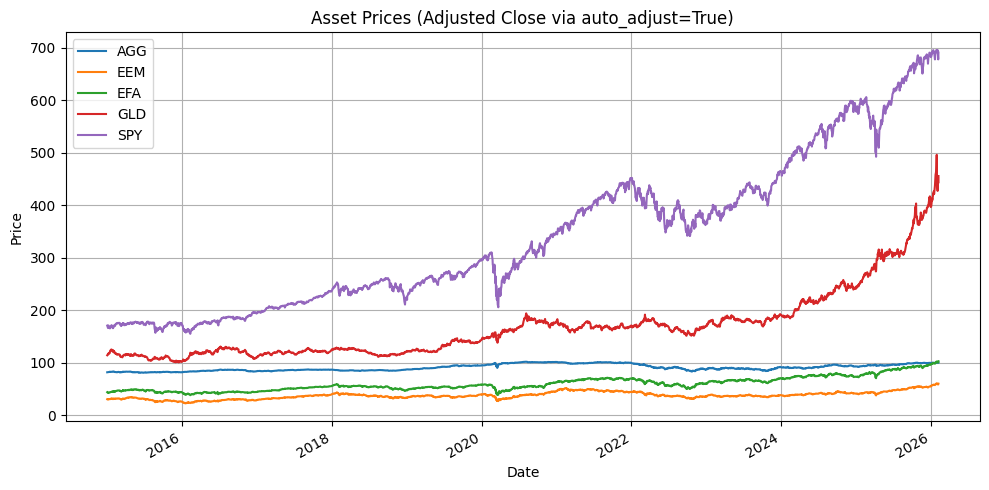

,Equal Weight (ALT),MinVar (ALT),MaxSharpe (ALT)
Ticker,,,
AGG,0.2,0.2,0.240987
EEM,0.2,0.2,0.000000
EFA,0.2,0.2,0.000000
GLD,0.2,0.2,0.400000
SPY,0.2,0.2,0.359013


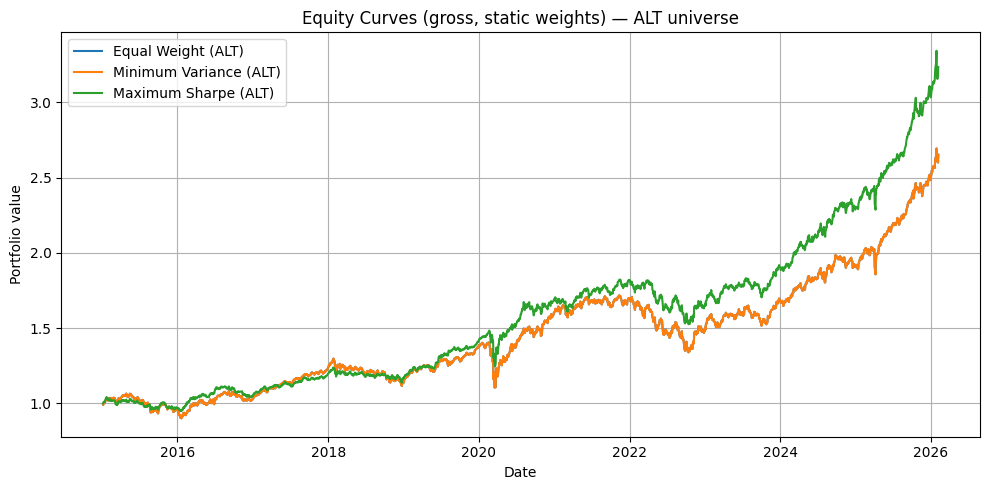

,Equal Weight (ALT),Minimum Variance (ALT),Maximum Sharpe (ALT)
CAGR,0.092081,0.092081,0.111860
Volatility,0.114216,0.114216,0.094892
Sharpe,0.828608,0.828608,1.165130
Max Drawdown,-0.220389,-0.220389,-0.162522


,Equal Weight (ALT),Minimum Variance (ALT),Maximum Sharpe (ALT)
Sortino,1.061968,1.061968,1.505902
Calmar,0.417812,0.417812,0.688275
VaR 95%,-0.010645,-0.010645,-0.008680
VaR 99%,-0.017966,-0.017966,-0.016015


Walk-forward period: 2017-01-04 00:00:00 -> 2026-01-12 00:00:00
WF length: 2268


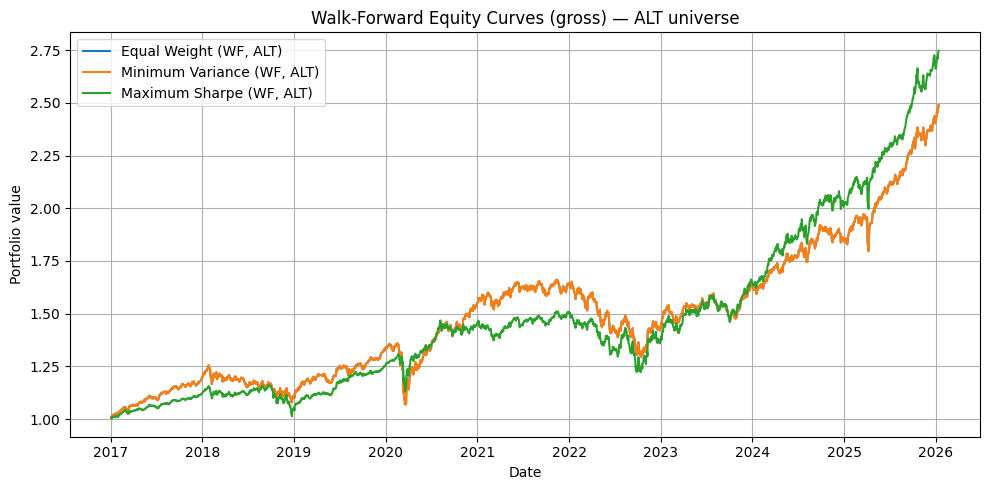

,"Equal Weight (WF, ALT)","Minimum Variance (WF, ALT)","Maximum Sharpe (WF, ALT)"
CAGR,0.106670,0.106670,0.118874
Volatility,0.116350,0.116350,0.102865
Sharpe,0.929644,0.929644,1.143583
Max Drawdown,-0.220389,-0.220389,-0.189951


,"Equal Weight (WF, ALT)","Minimum Variance (WF, ALT)","Maximum Sharpe (WF, ALT)"
Sortino,1.159337,1.159337,1.469917
Calmar,0.484008,0.484008,0.625814
VaR 95%,-0.010337,-0.010337,-0.010064
VaR 99%,-0.018401,-0.018401,-0.017738


,"Equal Weight (WF, ALT)","Minimum Variance (WF, ALT)","Maximum Sharpe (WF, ALT)"
Beta,0.539939,0.539939,0.421848
Alpha (annualized),0.030042,0.030042,0.056600


Equal Weight (WF, ALT)        0.200326
Minimum Variance (WF, ALT)    0.200326
Maximum Sharpe (WF, ALT)      0.278856
Name: Treynor Ratio, dtype: float64

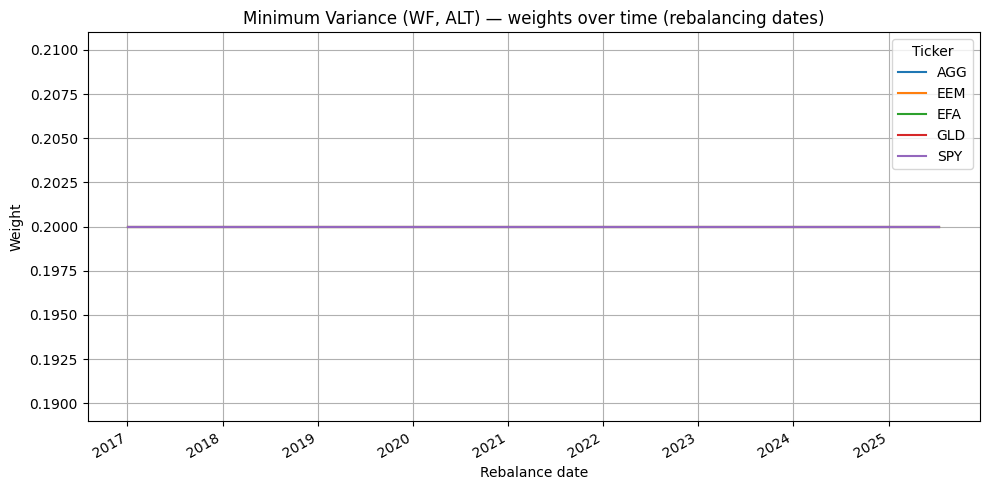

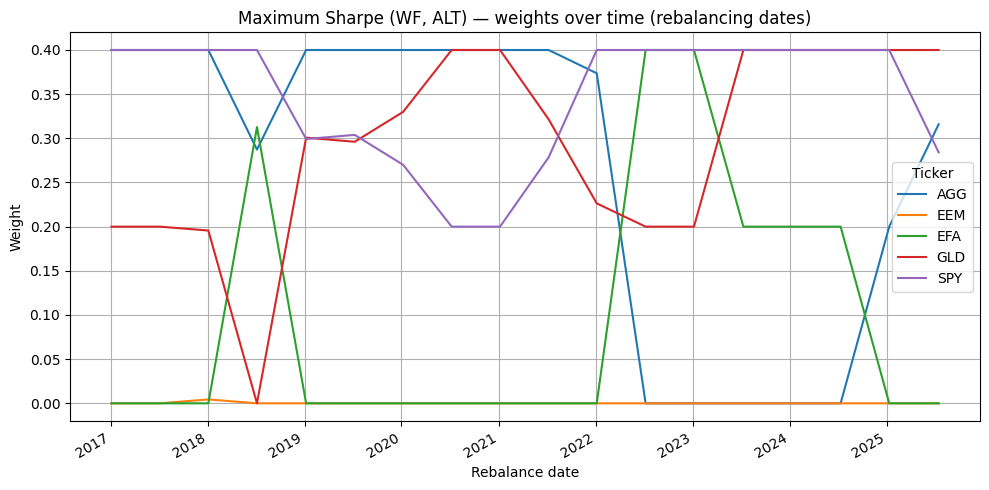

Saved figures in: C:\Users\mathi\Desktop\GIT\portfolio-optimization-methods\reports\figures


In [71]:


from pathlib import Path
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 0) Output dir (GitHub-ready)

FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 1) Config (CHANGE HERE)

TICKERS_ALT = ["SPY", "EFA", "EEM", "AGG", "GLD"]   # diversified ETFs (example)
START_DATE_ALT = "2015-01-01"
END_DATE_ALT = None  # None = today

# Constraints
MAX_WEIGHT = 0.40  # cap per asset (same idea as before)
LONG_ONLY = True

# Walk-forward parameters (in trading days)
FREQ = 252
TRAIN_WINDOW = 252 * 2   # 2 years train
TEST_WINDOW  = 252 // 2  # 6 months test
STEP_WINDOW  = TEST_WINDOW

# Benchmark for CAPM metrics
BENCHMARK = "^GSPC"  # S&P 500

# Risk-free rate (annual, approx; keep 0.0 if you want)
RF_ANNUAL = 0.0

# 2) Helpers

def download_prices(tickers, start, end=None):
    """
    Robust Yahoo Finance download.
    Uses auto_adjust=True so we get adjusted prices directly in 'Close'.
    """
    df = yf.download(
        tickers,
        start=start,
        end=end,
        auto_adjust=True,
        progress=False
    )
    # With auto_adjust=True, adjusted prices are in 'Close'
    if isinstance(df.columns, pd.MultiIndex):
        px = df["Close"].copy()
    else:
        # Single ticker case: df is 1-column
        px = df[["Close"]].copy()
        px.columns = [tickers[0]] if isinstance(tickers, list) else ["Close"]

    px = px.dropna(how="any")
    return px

def returns_from_prices(prices: pd.DataFrame) -> pd.DataFrame:
    rets = prices.pct_change().dropna()
    return rets

def portfolio_returns(returns: pd.DataFrame, weights: pd.Series) -> pd.Series:
    # align
    w = weights.reindex(returns.columns).values
    return (returns.values @ w)

def equity_curve(returns: pd.Series, start_value=1.0) -> pd.Series:
    return pd.Series((1 + returns).cumprod() * start_value, index=returns.index)

def compute_metrics(portfolio_returns: pd.Series, equity: pd.Series, freq=252) -> pd.Series:
    # CAGR from equity curve
    n = len(equity)
    cagr = equity.iloc[-1] ** (freq / n) - 1

    vol = portfolio_returns.std() * np.sqrt(freq)
    sharpe = (portfolio_returns.mean() * freq) / (portfolio_returns.std() * np.sqrt(freq))

    running_max = equity.cummax()
    drawdown = equity / running_max - 1
    max_dd = drawdown.min()

    return pd.Series({
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd
    })

def downside_volatility(returns: pd.Series, freq=252) -> float:
    down = returns[returns < 0]
    if len(down) == 0:
        return 0.0
    return down.std() * np.sqrt(freq)

def sortino_ratio(returns: pd.Series, rf_annual=0.0, freq=252) -> float:
    # annualized excess return / downside vol
    rf_daily = rf_annual / freq
    excess_daily = returns - rf_daily
    denom = downside_volatility(excess_daily, freq=freq)
    if denom == 0:
        return np.nan
    return (excess_daily.mean() * freq) / denom

def calmar_ratio(returns: pd.Series, equity: pd.Series, freq=252) -> float:
    m = compute_metrics(returns, equity, freq=freq)
    if m["Max Drawdown"] == 0:
        return np.nan
    return m["CAGR"] / abs(m["Max Drawdown"])

def historical_var(returns: pd.Series, q=0.95) -> float:
    # returns quantile at (1-q)
    return returns.quantile(1 - q)

def capm_alpha_beta(strategy_returns: pd.Series, benchmark_returns: pd.Series, rf_annual=0.0, freq=252) -> pd.Series:
    # Align
    df = pd.concat([strategy_returns, benchmark_returns], axis=1, join="inner").dropna()
    df.columns = ["strategy", "benchmark"]

    rf_daily = rf_annual / freq
    excess_s = df["strategy"] - rf_daily
    excess_m = df["benchmark"] - rf_daily

    beta = excess_s.cov(excess_m) / excess_m.var()

    # daily alpha = mean(excess_s - beta*excess_m), then annualize
    alpha_daily = (excess_s - beta * excess_m).mean()
    alpha_annual = alpha_daily * freq

    return pd.Series({"Beta": beta, "Alpha (annualized)": alpha_annual})

def treynor_ratio(strategy_returns: pd.Series, beta: float, rf_annual=0.0, freq=252) -> float:
    rf_daily = rf_annual / freq
    excess_return_annual = (strategy_returns.mean() - rf_daily) * freq
    if beta == 0:
        return np.nan
    return excess_return_annual / beta


# 3) Optimization blocks

def cov_matrix(returns: pd.DataFrame) -> np.ndarray:
    return returns.cov().values

def min_variance_weights(returns: pd.DataFrame, max_weight=0.4) -> pd.Series:
    Sigma = cov_matrix(returns)
    n = returns.shape[1]

    def obj(w):
        return float(w.T @ Sigma @ w)

    # constraints: sum w = 1
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
    bounds = tuple((0.0, max_weight) for _ in range(n))
    w0 = np.repeat(1/n, n)

    res = minimize(obj, w0, method="SLSQP", bounds=bounds, constraints=cons)
    w = res.x
    return pd.Series(w, index=returns.columns)

def max_sharpe_weights(returns: pd.DataFrame, max_weight=0.4, rf_annual=0.0, freq=252) -> pd.Series:
    """
    Maximize Sharpe using sample mean and cov.
    We maximize (mu - rf)/sqrt(w' Sigma w).
    Equivalent: minimize negative Sharpe.
    """
    Sigma = cov_matrix(returns)
    mu = returns.mean().values * freq 
    rf = rf_annual

    n = returns.shape[1]

    def neg_sharpe(w):
        port_ret = float(w @ mu)
        port_vol = float(np.sqrt(w.T @ Sigma @ w) * np.sqrt(freq))  
        
        if port_vol == 0:
            return 1e9
        return - (port_ret - rf) / port_vol

    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
    bounds = tuple((0.0, max_weight) for _ in range(n))
    w0 = np.repeat(1/n, n)

    res = minimize(neg_sharpe, w0, method="SLSQP", bounds=bounds, constraints=cons)
    w = res.x
    return pd.Series(w, index=returns.columns)


# 4) Download + Returns (ALT)

prices_alt = download_prices(TICKERS_ALT, START_DATE_ALT, END_DATE_ALT)
returns_alt = returns_from_prices(prices_alt)

print("ALT universe:", list(prices_alt.columns))
print("Prices shape:", prices_alt.shape, "| Returns shape:", returns_alt.shape)
display(prices_alt.head())
display(returns_alt.head())

# Price plot (GitHub figure)
plt.figure()
prices_alt.plot(ax=plt.gca())
plt.title("Asset Prices (Adjusted Close via auto_adjust=True)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "alt_prices.png", dpi=200, bbox_inches="tight")
plt.show()

# 5) STATIC portfolios (ALT)

n_alt = returns_alt.shape[1]
w_eq_alt = pd.Series(np.repeat(1/n_alt, n_alt), index=returns_alt.columns, name="Equal Weight (ALT)")

w_minvar_alt = min_variance_weights(returns_alt, max_weight=MAX_WEIGHT).rename("MinVar (ALT)")
w_maxsh_alt  = max_sharpe_weights(returns_alt, max_weight=MAX_WEIGHT, rf_annual=RF_ANNUAL, freq=FREQ).rename("MaxSharpe (ALT)")

display(pd.concat([w_eq_alt, w_minvar_alt, w_maxsh_alt], axis=1))

# Static equity curves
ret_eq_alt = pd.Series(portfolio_returns(returns_alt, w_eq_alt), index=returns_alt.index)
ret_mv_alt = pd.Series(portfolio_returns(returns_alt, w_minvar_alt), index=returns_alt.index)
ret_ms_alt = pd.Series(portfolio_returns(returns_alt, w_maxsh_alt), index=returns_alt.index)

eq_eq_alt = equity_curve(ret_eq_alt)
eq_mv_alt = equity_curve(ret_mv_alt)
eq_ms_alt = equity_curve(ret_ms_alt)

# Plot static comparison
plt.figure()
plt.plot(eq_eq_alt, label="Equal Weight (ALT)")
plt.plot(eq_mv_alt, label="Minimum Variance (ALT)")
plt.plot(eq_ms_alt, label="Maximum Sharpe (ALT)")
plt.title("Equity Curves (gross, static weights) — ALT universe")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "alt_equity_curve_comparison_static.png", dpi=200, bbox_inches="tight")
plt.show()

# Static metrics
metrics_static_alt = pd.DataFrame({
    "Equal Weight (ALT)": compute_metrics(ret_eq_alt, eq_eq_alt, freq=FREQ),
    "Minimum Variance (ALT)": compute_metrics(ret_mv_alt, eq_mv_alt, freq=FREQ),
    "Maximum Sharpe (ALT)": compute_metrics(ret_ms_alt, eq_ms_alt, freq=FREQ),
})
display(metrics_static_alt)

# Advanced metrics (static)
advanced_static_alt = pd.DataFrame({
    "Equal Weight (ALT)": {
        "Sortino": sortino_ratio(ret_eq_alt, rf_annual=RF_ANNUAL, freq=FREQ),
        "Calmar": calmar_ratio(ret_eq_alt, eq_eq_alt, freq=FREQ),
        "VaR 95%": historical_var(ret_eq_alt, q=0.95),
        "VaR 99%": historical_var(ret_eq_alt, q=0.99),
    },
    "Minimum Variance (ALT)": {
        "Sortino": sortino_ratio(ret_mv_alt, rf_annual=RF_ANNUAL, freq=FREQ),
        "Calmar": calmar_ratio(ret_mv_alt, eq_mv_alt, freq=FREQ),
        "VaR 95%": historical_var(ret_mv_alt, q=0.95),
        "VaR 99%": historical_var(ret_mv_alt, q=0.99),
    },
    "Maximum Sharpe (ALT)": {
        "Sortino": sortino_ratio(ret_ms_alt, rf_annual=RF_ANNUAL, freq=FREQ),
        "Calmar": calmar_ratio(ret_ms_alt, eq_ms_alt, freq=FREQ),
        "VaR 95%": historical_var(ret_ms_alt, q=0.95),
        "VaR 99%": historical_var(ret_ms_alt, q=0.99),
    },
})
display(advanced_static_alt)

# 6) Walk-forward backtest (ALT)

# Build rolling windows on ALT returns
rets = returns_alt.copy()
n_days = len(rets)
start_idx = TRAIN_WINDOW
end_idx = n_days - TEST_WINDOW
wf_starts = list(range(start_idx, end_idx + 1, STEP_WINDOW))

wf_returns_eq = []
wf_returns_mv = []
wf_returns_ms = []
wf_weights_mv = []
wf_weights_ms = []

for s in wf_starts:
    train = rets.iloc[s-TRAIN_WINDOW:s]
    test  = rets.iloc[s:s+TEST_WINDOW]

    # Equal weight (kept constant) — but applied out-of-sample on test window
    w_eq = pd.Series(np.repeat(1/train.shape[1], train.shape[1]), index=train.columns)

    # Optimize on train only
    w_mv = min_variance_weights(train, max_weight=MAX_WEIGHT)
    w_ms = max_sharpe_weights(train, max_weight=MAX_WEIGHT, rf_annual=RF_ANNUAL, freq=FREQ)

    wf_weights_mv.append(w_mv.rename(test.index[0]))
    wf_weights_ms.append(w_ms.rename(test.index[0]))

    # Out-of-sample returns
    wf_returns_eq.append(pd.Series(portfolio_returns(test, w_eq), index=test.index))
    wf_returns_mv.append(pd.Series(portfolio_returns(test, w_mv), index=test.index))
    wf_returns_ms.append(pd.Series(portfolio_returns(test, w_ms), index=test.index))

wf_returns_eq = pd.concat(wf_returns_eq).sort_index()
wf_returns_mv = pd.concat(wf_returns_mv).sort_index()
wf_returns_ms = pd.concat(wf_returns_ms).sort_index()

wf_eq_eq = equity_curve(wf_returns_eq)
wf_eq_mv = equity_curve(wf_returns_mv)
wf_eq_ms = equity_curve(wf_returns_ms)

print("Walk-forward period:", wf_returns_eq.index.min(), "->", wf_returns_eq.index.max())
print("WF length:", len(wf_returns_eq))

# Plot walk-forward equity curves (ALT)
plt.figure()
plt.plot(wf_eq_eq, label="Equal Weight (WF, ALT)")
plt.plot(wf_eq_mv, label="Minimum Variance (WF, ALT)")
plt.plot(wf_eq_ms, label="Maximum Sharpe (WF, ALT)")
plt.title("Walk-Forward Equity Curves (gross) — ALT universe")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "alt_equity_curve_walkforward.png", dpi=200, bbox_inches="tight")
plt.show()

# WF performance metrics
wf_metrics_alt = pd.DataFrame({
    "Equal Weight (WF, ALT)": compute_metrics(wf_returns_eq, wf_eq_eq, freq=FREQ),
    "Minimum Variance (WF, ALT)": compute_metrics(wf_returns_mv, wf_eq_mv, freq=FREQ),
    "Maximum Sharpe (WF, ALT)": compute_metrics(wf_returns_ms, wf_eq_ms, freq=FREQ),
})
display(wf_metrics_alt)

wf_advanced_alt = pd.DataFrame({
    "Equal Weight (WF, ALT)": {
        "Sortino": sortino_ratio(wf_returns_eq, rf_annual=RF_ANNUAL, freq=FREQ),
        "Calmar": calmar_ratio(wf_returns_eq, wf_eq_eq, freq=FREQ),
        "VaR 95%": historical_var(wf_returns_eq, q=0.95),
        "VaR 99%": historical_var(wf_returns_eq, q=0.99),
    },
    "Minimum Variance (WF, ALT)": {
        "Sortino": sortino_ratio(wf_returns_mv, rf_annual=RF_ANNUAL, freq=FREQ),
        "Calmar": calmar_ratio(wf_returns_mv, wf_eq_mv, freq=FREQ),
        "VaR 95%": historical_var(wf_returns_mv, q=0.95),
        "VaR 99%": historical_var(wf_returns_mv, q=0.99),
    },
    "Maximum Sharpe (WF, ALT)": {
        "Sortino": sortino_ratio(wf_returns_ms, rf_annual=RF_ANNUAL, freq=FREQ),
        "Calmar": calmar_ratio(wf_returns_ms, wf_eq_ms, freq=FREQ),
        "VaR 95%": historical_var(wf_returns_ms, q=0.95),
        "VaR 99%": historical_var(wf_returns_ms, q=0.99),
    },
})
display(wf_advanced_alt)

# 7) Benchmark + CAPM (WF, ALT)

bench_px = yf.download(
    BENCHMARK,
    start=wf_returns_eq.index.min(),
    end=wf_returns_eq.index.max(),
    auto_adjust=True,
    progress=False
)

# robust column selection (auto_adjust -> Close)
if isinstance(bench_px.columns, pd.MultiIndex):
    bench_prices = bench_px["Close"].dropna()
else:
    bench_prices = bench_px["Close"].dropna()

bench_returns = bench_prices.pct_change().dropna()

capm_alt = pd.DataFrame({
    "Equal Weight (WF, ALT)": capm_alpha_beta(wf_returns_eq, bench_returns, rf_annual=RF_ANNUAL, freq=FREQ),
    "Minimum Variance (WF, ALT)": capm_alpha_beta(wf_returns_mv, bench_returns, rf_annual=RF_ANNUAL, freq=FREQ),
    "Maximum Sharpe (WF, ALT)": capm_alpha_beta(wf_returns_ms, bench_returns, rf_annual=RF_ANNUAL, freq=FREQ),
})
display(capm_alt)

treynor_alt = pd.Series({
    "Equal Weight (WF, ALT)": treynor_ratio(wf_returns_eq, capm_alt.loc["Beta", "Equal Weight (WF, ALT)"], rf_annual=RF_ANNUAL, freq=FREQ),
    "Minimum Variance (WF, ALT)": treynor_ratio(wf_returns_mv, capm_alt.loc["Beta", "Minimum Variance (WF, ALT)"], rf_annual=RF_ANNUAL, freq=FREQ),
    "Maximum Sharpe (WF, ALT)": treynor_ratio(wf_returns_ms, capm_alt.loc["Beta", "Maximum Sharpe (WF, ALT)"], rf_annual=RF_ANNUAL, freq=FREQ),
}, name="Treynor Ratio")
display(treynor_alt)

# 8) Weight dynamics plots (WF, ALT)

wf_w_mv = pd.DataFrame(wf_weights_mv)
wf_w_ms = pd.DataFrame(wf_weights_ms)

plt.figure()
wf_w_mv.plot(ax=plt.gca())
plt.title("Minimum Variance (WF, ALT) — weights over time (rebalancing dates)")
plt.xlabel("Rebalance date")
plt.ylabel("Weight")
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_DIR / "alt_weights_minvar_walkforward.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure()
wf_w_ms.plot(ax=plt.gca())
plt.title("Maximum Sharpe (WF, ALT) — weights over time (rebalancing dates)")
plt.xlabel("Rebalance date")
plt.ylabel("Weight")
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_DIR / "alt_weights_maxsharpe_walkforward.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved figures in:", FIG_DIR.resolve())


### Interpretation: Weight Dynamics

- The Minimum Variance portfolio exhibits perfectly stable weights across
  rebalancing dates. This indicates that, for this diversified asset universe,
  variance minimization naturally leads to an equal-weight–like allocation.

- In contrast, the Maximum Sharpe portfolio displays highly unstable and
  concentrated weights, frequently hitting the imposed weight bounds.
  This behavior reflects the extreme sensitivity of return-driven optimization
  to estimation error in expected returns.

- Walk-forward backtesting highlights this instability, emphasizing why
  Maximum Sharpe portfolios are often impractical without additional
  regularization or constraints.
